# Disambiguation
This notebook is written for name disambiguation. We distinguish different researcher sharing same name by their subjects.

To reproduce the result one will first need to download [GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit). We did not include it in our submission for its large size.

The data is obtained by web scraping  using extended version of web of science. The search strategy is searching the full family name + first letter of given name (eg. For some one ’Tom Smith’ we search ‘Smith T\*’). With this strategy, WOS will return far more records than just searching ‘Smith Tom’. But it will arise another important problem: the name disambiguation. Name disambiguation can occur when one is seeking a list of publications of an author who has used different name variations and when there are multiple other authors with the same name. So before we proceed to classification, we need first distinguish the correct author of each paper (eg. Paper written by Smith Tom and Smith Tim). 

Web of science has a unique id (daisng id) for each author, and this daisng id should help distinguish different authors sharing same names. However, as mentioned by the lab, the daisng id is not working very well. So we have to do disambiguation by ourselves.

And methods used include:

1. word2vec;
2. kNN classification;
3. LOF outlier detection;
4. t-SNE visualization.

---
## 0 Loading libraries and data

In [1]:
import pandas as pd
import math
import numpy as np
import gensim
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import sklearn.cluster

In [2]:
import re
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances,euclidean_distances
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
import string
from sklearn.neighbors import LocalOutlierFactor

In [4]:
# data_dismiss = pd.read_csv('../ScarpAndParse/dismissed_complete.csv')
# data_dismiss = data_dismiss.loc[(data_dismiss.doctype=='Article')|(data_dismiss.doctype=='Meeting Abstract')|\
# (data_dismiss.doctype=='Proceedings Paper')|(data_dismiss.doctype=='Review')]
# data_dismiss = data_dismiss.reset_index(drop=True)

In [5]:
# data_dismiss.info()

In [6]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

---
## 1 Data pre-processing
In this part we extract all papers include author `DOGAN M` and try to match the authors' fullname and affiliation. And for papers where no clear fullname and affiliation is found, we label them with -2 in function `CleanNonAff`, and later will perform kNN on these papers and try to find to which author they belong to.

Also, we calculate the averaged subject vectors for each paper and use them as feature after standardization.

In `auth_names` there are the full list of dismissed Turkey researchers (include full name, abbreviation name and affiliation). In `auth` we picked out the authors with same abbreviation name :'DOGAN M'.

In [7]:
# auth_names = pd.read_csv('./author_df_nodup_aff.csv')
# auth_names = auth_names[['Author','AbbrNames','Affiliation']]
# auth_names = auth_names.drop_duplicates()
# auth_names = auth_names.reset_index(drop=True)
# auth_names['Affiliation'] = auth_names['Affiliation'].map(lambda x: x.replace('UNIVERSITY', 'UNIV')\
#                                                                 if 'UNIVERSITY' in x else x)
# auth_names.head(2)

In [8]:
Abbrname = 'DOGAN M'
MatchName = '\''+Abbrname+'\*'

In [9]:
#auth = auth_names.loc[auth_names.AbbrNames==Abbrname]
auth = pd.read_csv('./data/auth_for_reproduce.csv')
auth

,Author,AbbrNames,Affiliation
0,DOGAN METIN,DOGAN M,INONU UNIV
1,DOGAN MEVLUT,DOGAN M,AFYON KOCATEPE UNIV
2,DOGAN MUAMMER,DOGAN M,AKSARAY UNIV
3,DOGAN MURAT,DOGAN M,YUZUNCU YIL UNIV
4,DOGAN MUSTAFA,DOGAN M,PAMUKKALE UNIV
5,DOGAN MUZAFFER,DOGAN M,ANADOLU UNIV


In [10]:
pd.set_option('max_colwidth', 100)
# unlabelled = data_dismiss.loc[data_dismiss.AbbrNames.str.contains(MatchName)].copy()
# unlabelled.dropna(subset=['uid'],inplace=True)
# unlabelled.drop_duplicates(subset=['uid'],inplace=True)
# unlabelled = unlabelled.dropna(subset=['keywords'])
# unlabelled = unlabelled.reset_index(drop=True)
unlabelled = pd.read_csv('./data/data_for_reproduce.csv')
unlabelled.head(2)

,doctype,keywords,language,name_info,publish_date,pubtype,source,title,AbbrNames,uid,heading,subheading,traditional_sub,extended_sub
0,Article,"['Carotid artery', 'intima-media thickness', 'ultrasonography', 'aging', 'children', 'sex differ...",['English'],"{'KOCYIGIT A*': {'daisng_id': '456214', 'role': 'author', 'seq_no': '1', 'display_name': 'Kocyig...",2014-01-01,Journal,TURKISH JOURNAL OF MEDICAL SCIENCES,Relation of age and sex with carotid intima media thickness in healthy children,"['KOCYIGIT A*', 'DOGAN M*', 'YILMAZ I*', 'CAGLAR M*', 'HATIPOGLU C*', 'KOCYIGIT F*', 'HEREK D*',...",WOS:000334063700013,['Science & Technology'],['Life Sciences & Biomedicine'],"['Medicine, General & Internal']",['General & Internal Medicine']
1,Article,"['Hyaluronic acid', 'Peripheral nerve regeneration', 'PRP', 'PLATELET-RICH PLASMA', 'SCIATIC-NER...",['English'],"{'FIRAT C*': {'daisng_id': '1200199', 'role': 'author', 'seq_no': '1', 'display_name': 'Firat, C...",2016-07-01,Journal,ANNALI ITALIANI DI CHIRURGIA,Comparison of the effects of PRP and hyaluronic acid in promoting peripheral nerve regeneration ...,"['FIRAT C*', 'AYTEKIN A*', 'DURAK M*', 'GEYIK Y*', 'ERBATUR S*', 'DOGAN M*', 'ELMAS O*', 'DAGLI ...",WOS:000391346000014,['Science & Technology'],['Life Sciences & Biomedicine'],['Surgery'],['Surgery']


In [11]:
def paper_sub2vec(paper_df,w2v_model,Abbrname):
    """
    The function is used to convert subjects in each paper into averaged vector.
    
    Inputs:
        paper_df: Dataframe containing paper information.
        w2v_model: word2vec model.
        Abbrname: The abbreviation name we are looking for.
    Return:
        paper_vec_df: Dataframe containing title, display name, affiliation, subject, sequence number, daisng id and subject vectors.
    """
    paper_vec_df = pd.DataFrame(columns=['Title','Disp_name','Aff','Sub','seq_no','daisng_id'])
    for i in range(len(paper_df)):
        test = paper_df.iloc[i]
        test = pd.DataFrame(test).T
        test.reset_index(inplace=True)
        tmp_sub = paper_df.iloc[i].Sub
        if tmp_sub:
            tmp_vec = 0
            for sub in tmp_sub:
                tmp_vec += w2v_model[string.capwords(sub)]
            avg_vec = tmp_vec/len(tmp_sub)
            avg_df = pd.DataFrame(avg_vec, dtype='float64').T
            test = pd.concat([test,avg_df],axis=1)
            paper_vec_df = paper_vec_df.append(test) 
        else:
            paper_vec_df = paper_vec_df.append(test)
            continue
    paper_vec_df = paper_vec_df.reset_index(drop=True)
    paper_vec_df.drop(columns=['index'],inplace=True)
    #paper_vec_df = pd.concat([paper_vec_df,paper_df.iloc[:,-1*NumCluster:]],axis=1)
    return paper_vec_df

In [12]:
def df_clean(paper_df,Abbrname):
    paper_vec_df = pd.DataFrame(columns=['Title','Disp_name','Aff','Sub','seq_no','daisng_id','keywords'])
    for i in range(len(paper_df)):
        Title = paper_df.iloc[i].title
        disp_name,seq_no,daisng_id = FindDispName(paper_df,Abbrname,i)
        # if no pre-known affiliation then try to find it 
        # Aff = None if pd.isnull(paper_df.iloc[i].Affiliation) else FindAff(paper_df,Abbrname,i)
        Aff = FindAff(paper_df,Abbrname,i)
        # if the subject from dataframe exists then try to split it
        Heading = None if pd.isnull(paper_df.iloc[i].heading) else FindHead(paper_df,i)
        Sub = None if pd.isnull(paper_df.iloc[i].traditional_sub) else FindSub(paper_df,i)
        if Heading:
            if Sub:
                Heading_Sub = Heading + Sub
            else:
                Heading_Sub = Heading
        elif Sub:
            Heading_Sub = Sub
        else:
            Heading_Sub = None
        #Label = paper_df.iloc[i].Label
        test = pd.DataFrame({'Title':[Title],'Disp_name':[disp_name],'Aff':[Aff],'Sub':[Heading_Sub],\
                             'seq_no':seq_no,'daisng_id':daisng_id,'keywords':paper_df.iloc[i].keywords})
        paper_vec_df = paper_vec_df.append(test) 
    paper_vec_df = paper_vec_df.reset_index(drop=True)
    #paper_vec_df = pd.concat([paper_vec_df,paper_df.iloc[:,-1*NumCluster:]],axis=1)
    return paper_vec_df

In [13]:
def FindAff(paper_df,Abbrname,idx):
    """
    Find affiliation of given paper.
    Only under two circumstance affiliation is found:
        1. Only one address in one paper(it means all the authors of that paper come from same affiliation)
        2. The number of addresses equal to number of authors of that paper(it means the addresses and authors are corresponding one to one)
    Otherwise, we will return None, indicating the relationship of author and affiliation is uncertain.
    """
    tmp_dict = eval(paper_df.iloc[idx].name_info)
    tmp_dict = tmp_dict[Abbrname+'*']
    if tmp_dict.__contains__('address'):
        affliation = tmp_dict['address']['organization']
    elif tmp_dict.__contains__('addr_no_1') & ~tmp_dict.__contains__('addr_no_2'):
        affliation = tmp_dict['addr_no_1']['organization']
    else:
        # print('No address found.')
        affliation = None
    return affliation

In [14]:
def FindDispName(paper_df,Abbrname,idx):
    """
    Return display name of paper.
    """
    tmp_dict = eval(paper_df.iloc[idx].name_info)
    tmp_dict = tmp_dict[Abbrname+'*']
    if tmp_dict.__contains__('display_name'):
        disp_name = ' ' .join(list(filter(None,re.split(r"\W+",tmp_dict['display_name']))))
        disp_name = disp_name.upper()
    else:
        disp_name = None
    seq_no = int(tmp_dict['seq_no']) if tmp_dict['seq_no'] else None
    daisng_id = int(tmp_dict['daisng_id']) if tmp_dict['daisng_id'] else None
    return disp_name,seq_no,daisng_id

In [15]:
def FindHead (paper_df,idx):
    """
    Return heading of paper.
    """
    try:
        heading_tmp = eval(paper_df.iloc[idx].subheading)
        heading = []
        for head in heading_tmp:
            #heading.append('_'.join(list(filter(None,re.split(r"\W+",head)))))
            heading+=(list(filter(None,re.split(r"\W+",head.lower()))))
    except:
        heading = None
    return heading

In [16]:
def FindSub (paper_df,idx):
    """
    Return subjects of paper.
    """
    try:
        subject_tmp = eval(paper_df.iloc[idx].traditional_sub)
        subject = []
        for sub in subject_tmp:
            # eg. return life_science or ['life','science']
            # subject.append('_'.join(list(filter(None,re.split(r"\W+",sub)))))
            subject+=(list(filter(None,re.split(r"\W+",sub.lower()))))
    except:
        subject = None
    return subject

In [17]:
def AvgSubVec(sublist,model):
    """
    Return averaged subject vectors.
    """
    sub2vec = 0
    for sub in sublist:
        # sub2vec += model[sub.lower()]
        sub2vec += model[string.capwords(sub)]
    return sub2vec/len(sublist)

In [18]:
def CleanNonAff(df,auth_df,abbr):
    """
    This function is used to find where the affiliation of author is uncertain.
    """
    tmp = df.loc[pd.isnull(df.Aff)].copy()
    names = auth_df.Author.get_values()
    names[-1] = abbr
    label = np.zeros(len(tmp))
    for i in range(len(tmp)):
        tmp_name = tmp.iloc[i].Disp_name
        # -1 means the name is not equal to dismissed researchers and is definitely not the one we are looking for
        # -2 means we are still not confident in the researcher and this paper need to be performed disambiguation
        label[i] = -2 if tmp_name in names else -1
    tmp['Label'] = label
    return tmp

In [19]:
df_cleaned = df_clean(unlabelled,Abbrname)

In [20]:
paper_sub2vec_df = paper_sub2vec(df_cleaned,model,Abbrname)

Here we show an example why the original WOS disambiguation is not working very well. In WOS `daisng id` is unique and same `daisng id` means the same researcher. However, in following example, both `DOGAN MUSTAFA` are using same daisng id 314508, but from many aspects (affiliation, subject and keywords) we can hardly say they are actually the same researcher.

Thus, daisng id is not reliable and we should try new method.

In [21]:
paper_sub2vec_df.loc[[184,187]].iloc[:,:7]

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no
184,Dokuz Eylul Univ,DOGAN MUSTAFA,"[technology, physical, sciences, engineering, ocean, oceanography]",Experimental investigation of the equilibrium scour depth below submerged pipes both in live-bed...,314508,"['Wave', 'Submerged pipe', 'Scour regime', 'Equilibrium scour depth', 'Empirical equations', 'Ex...",1
187,Afyon Kocatepe Univ,DOGAN MUSTAFA,"[life, sciences, biomedicine, ophthalmology]",Laser-assisted dacryocystorhinostomy in nasolacrimal duct obstruction: 5-year follow-up,314508,"['nasolacrimal duct obstruction', 'laser-assisted dacryocystorhinostomy', '5-year follow-up', 'D...",1


---
## 2 kNN

In [22]:
paper_vec_test = paper_sub2vec_df.copy()
paper2cluster = CleanNonAff(paper_vec_test,auth.copy(),Abbrname)
X = paper2cluster.iloc[:,7:-1].dropna(how='all').get_values()
X = sklearn.preprocessing.scale(X)
y = paper2cluster.iloc[:,-1].get_values()
X_unlabeled = X[np.where(y==-2)] # -2 means the relationship between author and affiliation is not clear and need disambiguation

Actually WOS gives us the display name and address of authors in each paper. 

In some cases the display name is the full name of author and in the address we can find the affiliation. With full name and affiliation we can do simple disambiguation with high confidence( eg. Smith Tom from A Univ. vs Smith Tim from B Univ.). Unfortunately, the display name is not always the full name (eg. For an author Smith Kaye Bob, his display name could be Smith K., Smith Kaye Bob, Smith K. Bob or Smith KB), and many papers do not offer very clear relationship between the names and addresses (eg. If there are 4 names and 4 addresses in one paper, then the name and address is corresponding one by one; but in many cases we have 4 names and 3 or 2 addresses, and we cannot correspond the address with name). And we can these papers as ‘un-labeled’ in this project.

Below shows what we did in function `CleanNonAff`. We can see that first we extract all papers without clear affiliation (Aff: None). And then if the display name is in the 6 researchers in `auth` (full name or abbreviation name) then we label it as -2 (to be performed disambiguation). If the display name is author's fullname and it is not in the 6 researchers, we label it as -1 (discarded; no need to do anything afterwards).

Below, we label the first column as -1 because the display name DOGAN MEHMET is not in 6 researchers' name;
and seconde columns as -2 because we do not have the affiliation and the display name shows only the abbreviation.

In [23]:
paper2cluster.head(2)

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no,0,1,2,...,291,292,293,294,295,296,297,298,299,Label
15,None,DOGAN MEHMET,"[life, sciences, biomedicine, cardiac, cardiovascular, systems]",Circulating CD4+CD25+ T cells in rheumatic mitral stenosis,222417,"['DOPPLER ULTRASOUND', 'PERIPHERAL-BLOOD', 'VALVE DISEASE', 'PRESSURE', 'QUANTIFICATION', 'PATHO...",8,-0.228027,0.008067,0.309611,...,-0.079091,-0.312988,0.176921,0.165914,0.119548,-0.009847,0.012288,0.213674,0.049011,-1.0
19,None,DOGAN M,"[physical, sciences, polymer, science]",Study on conformational transition phenomena of poly(methyl methacrylate) in acetonitrile near t...,135243,"['poly(methyl methacrylate)', 'theta solvent', 'coil-globule transition', 'COIL-GLOBULE TRANSITI...",1,-0.112427,0.104401,0.163422,...,-0.058685,-0.345703,0.208740,0.146851,0.022745,-0.094482,0.085754,0.198853,0.013824,-2.0


Next we create data and label from labelled dataset `paper_vec_test` where the affiliation and full name authors are corresponding. And also, there is possibility that more than one researchers share same name and same affiliation. And we check this by point wise euclidean distances of each papers' subject vectors to the mean central. The idea behind is simple: we want to find the most relevant subjects of an author, subjects that the author is mainly working in and ignore papers in non relevant subjects. If the distance of subjects of some papers are far away from average, we will consider these papers are written by different researchers.

In [24]:
paper_vec_test.iloc[:,:7].head(5)

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no
0,Pamukkale Univ,DOGAN MUSTAFA,"[life, sciences, biomedicine, medicine, general, internal]",Relation of age and sex with carotid intima media thickness in healthy children,314508,"['Carotid artery', 'intima-media thickness', 'ultrasonography', 'aging', 'children', 'sex differ...",2
1,Dicle Univ,DOGAN METIN,"[life, sciences, biomedicine, surgery]",Comparison of the effects of PRP and hyaluronic acid in promoting peripheral nerve regeneration ...,551041,"['Hyaluronic acid', 'Peripheral nerve regeneration', 'PRP', 'PLATELET-RICH PLASMA', 'SCIATIC-NER...",6
2,Turkey Yuksek Ihtisas Hosp,DOGAN MEHMET,"[life, sciences, biomedicine, cardiac, cardiovascular, systems]",Impact of plasma adiponectin levels to the presence and severity of coronary artery disease in p...,222417,"['adiponectin', 'coronary artery disease', 'metabolic syndrome', 'CARDIOVASCULAR EVENTS', 'PROTE...",6
3,Turkiye Yuksek Ihtisas Hosp,DOGAN MEHMET,"[life, sciences, biomedicine, cardiac, cardiovascular, systems]",Relationship between inflammation and atrial fibrillation in patients with isolated rheumatic mi...,222417,"['C-REACTIVE PROTEIN', 'VALVE DISEASE', 'ADHESION MOLECULES', 'SIZE', 'THROMBOGENESIS', 'INTERLE...",6
4,Turkiye Yuksek Ihtisas Hosp,DOGAN MEHMET,"[life, sciences, biomedicine, cardiac, cardiovascular, systems, peripheral, vascular, disease]",Decreased plasma concentrations of adiponectin in patients with slow coronary flow,222417,"['Adiponectin', 'Slow coronary flow', 'Endothelial dysfunction', 'ADIPOSE-SPECIFIC PROTEIN', 'AD...",7


DOGAN METIN
(26,)
DOGAN MEVLUT
(42,)
DOGAN MUAMMER
DOGAN MURAT
(83,)
DOGAN MUSTAFA
(10,)
DOGAN MUZAFFER
(1,)


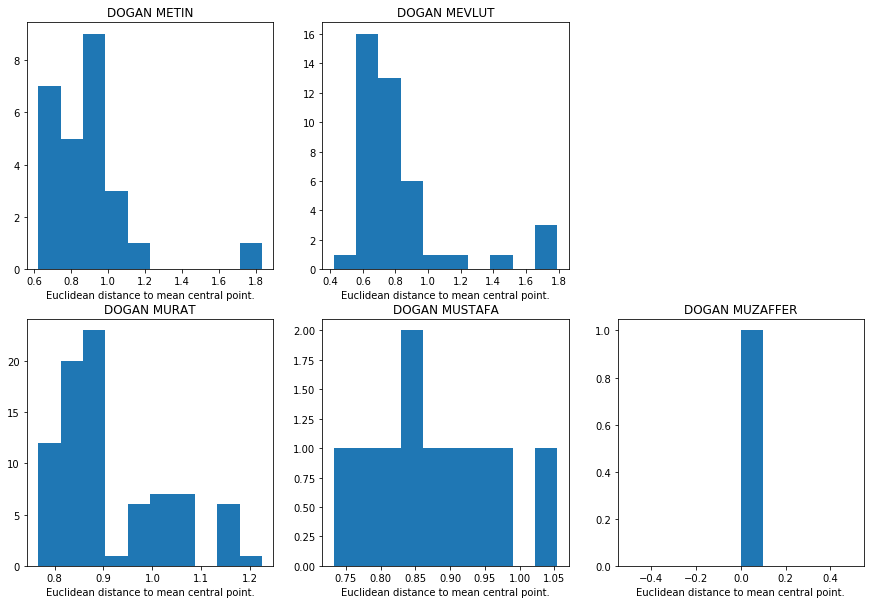

In [25]:
X_knn = np.empty(shape=[0, 300])
y_knn = []
eucld_thesh = 3
plt.figure(figsize=(15,10))
for i in range(len(auth)):
    auth_tmp = auth.Author.iloc[i]
    aff_tmp = auth.Affiliation.iloc[i]
    print(auth_tmp)
    X_tmp = paper_vec_test.loc[((paper_vec_test.Disp_name==auth_tmp)|(paper_vec_test.Disp_name==Abbrname))&(paper_vec_test.Aff.str.upper()==aff_tmp)]
    if X_tmp.empty:
        continue
    X_tmp = X_tmp.iloc[:,7:].dropna(how='any').get_values()
    X_mean_tmp = np.mean(X_tmp,0)
    eucld_tmp = euclidean_distances(X_tmp,np.mean(X_tmp,axis=0).reshape(1,-1))
    plt.subplot(2,3,i+1)
    plt.hist(eucld_tmp)
    plt.title(auth_tmp)
    plt.xlabel('Euclidean distance to mean central point.')
    X_knn = np.vstack((X_knn,X_tmp[np.where(eucld_tmp<eucld_thesh)[0]]))
    y_knn = y_knn+[i]*X_tmp[np.where(eucld_tmp<eucld_thesh)].shape[0]
    print(X_tmp[np.where(eucld_tmp<eucld_thesh)].shape)
X_knn = sklearn.preprocessing.scale(X_knn)
y_knn = np.array(y_knn)
cluster_type = np.unique(y_knn)

3 out of 6 researchers have more than 20 paper records in WOS. One author 'DOGAN MUAMMER' is not found. And 'DOGAN MUZAFFER' have very few records (only 1). Considering that kNN is very sensitive to outliers and the shape of each group should be similar, so here we choose DOGAN METIN, DOGAN MEVLUT, DOGAN MURAT and DOGAN MUSTAFA(label = 0,1,3,4 respectively).

The histogram plots of euclidean distance of subjects tell us that the basic disambiguation( only matching fullname and affiliation) works well on 'DOGAN M' since the distance of subjects are very small.

And we used t-SNE to show the samples in 2D plot. We can see that different authors have different subject clusters, so the idea to use subject vectors to do name disambiguation will work to some extent.

In [26]:
X_knn = X_knn[np.where(y_knn<4)[0]]
y_knn = y_knn[np.where(y_knn<4)[0]]

In [27]:
def TSNE_plot(X_toplot,label_toplot):
    """
    This function is used for high dimension visualization using t-SNE.
    
    Inputs:
        X_toplot,label_toplot: the data and label to be plotted.
    """
    X_tsne = TSNE(n_components=2, metric='cosine',perplexity=50,learning_rate=500).fit_transform(X_toplot)
    df_plot = pd.DataFrame(data=X_tsne, columns=['x','y'])
    df_plot['Labels'] = label_toplot
    df_plot['Labels'] = df_plot['Labels'].apply(lambda i: int(i))
    plt.figure(figsize=(10,6))
    sns.set(style="whitegrid")
    sns.scatterplot("x", "y", data=df_plot, palette='Paired',hue='Labels')
    plt.title('Cluster with T-SNE projections', fontsize=16)
    plt.show()
    #return df_plot

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=np.random)
knn = sklearn.neighbors.KNeighborsClassifier()
k_range = list(range(1,10))
leaf_range = [1,2,3,4,5]
weight_options = ['uniform','distance']
algorithm_options = ['auto','ball_tree','kd_tree','brute']
ps = [1,2]
param_gridknn = dict(p = ps,n_neighbors = k_range,weights = weight_options,algorithm=algorithm_options,leaf_size=leaf_range)

gridKNN = GridSearchCV(knn,param_gridknn,cv=5,scoring='accuracy',verbose=1)
gridKNN.fit(X_train,y_train)
print('best score is:',str(gridKNN.best_score_))
print('best params are:',str(gridKNN.best_params_))


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
best score is: 0.85
best params are: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done 3600 out of 3600 | elapsed:   49.7s finished


In [29]:
knn = sklearn.neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=2, n_neighbors=5, weights='uniform',p=2)
knn.fit(X_train, y_train)
knn.score(X_test,y_test)

0.7741935483870968

In [30]:
knn = sklearn.neighbors.KNeighborsClassifier(algorithm='auto', leaf_size=1, n_neighbors=5, weights='uniform',p=2)
knn.fit(X_knn, y_knn)
y_pred = knn.predict(X_unlabeled)

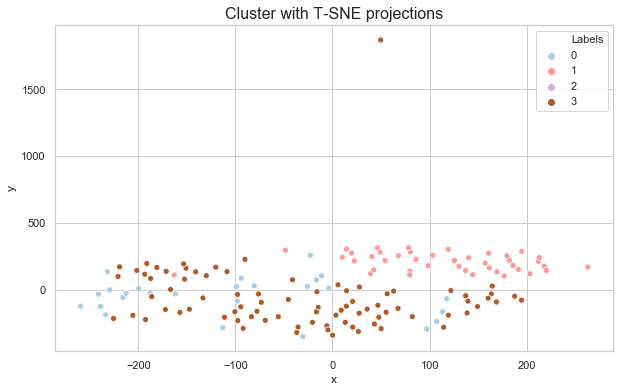

In [31]:
TSNE_plot(X_knn,y_knn)

---
## 3 LOF Outlier Detection
Then we used the kNN model to predict on unlabelled papers. Since we did not have all ‘DOGAN M\*’ in our dismissal list, papers written by other ‘DOGAN M\*’ may be misclassified into our ‘DOGAN M\*’. So in next step, we used LOF(local outlier factor) to detect these points as outliers. 

Local outlier factor is the anomaly score of each sample. It measures the local deviation of density of a given sample with respect to nearest neighbors. It is local in that the anomaly score depends on how isolated the object is in neighborhood. If one sample has lower density to its neighbour, then it is considered as outliers. Label is 1 for an inlier and -1 for an outlier.

In [32]:
def LOF_result(df_paper,df_auth,LOF_pred,ClusterNo,abbr):
    """
    Return the result of LOF outlier detection.
    1 means inlier, -1 means outlier.
    """
    # find the dataframe containing non-affiliation papers
    df = CleanNonAff(df_paper,df_auth,abbr)
    X_tmp = df.loc[df.Label==-2]
    X_tmp = X_tmp.iloc[np.where(y_pred==ClusterNo)]
    outlier = X_tmp#.iloc[:,0:7]
    # add column of LOF pred(1 inlier -1 outlier) and probability of kNN prediction
    outlier['LOF'] = LOF_pred
    outlier['kNN_prob'] = knn.predict_proba(X_unlabeled)[np.where(y_pred==ClusterNo)][:,np.where(np.unique(y_knn)==ClusterNo)[0]]
    
    # find the papers we have found belongs to i-th author
    auth_tmp = df_auth.Author.iloc[ClusterNo]
    aff_tmp = df_auth.Affiliation.iloc[ClusterNo]
    df_tmp = df_paper.loc[((df_paper.Disp_name==auth_tmp)|(df_paper.Disp_name==Abbrname))&(df_paper.Aff.str.upper()==aff_tmp)]
    return outlier,df_tmp

In [33]:
def word_cnt(df):
    """
    Count the frequency of words of given dataframe.
    """
    words=[]
    word_freq = df.copy()
    for j in range(len(word_freq)):
        words += list(filter(None, re.findall("[A-Za-z]*", str(word_freq.Sub.iloc[j]))))
    words_df = pd.DataFrame(words, columns=['Words'])
    return words_df.Words  

In [34]:
def get_jaccard_sim(str1, str2):
    """
    The function is used to calculate Jaccard distance between two cuisine ingredients.
    
    Parameters:
        str1,str2: Ingredients strings from cuisine1 and cuisine2.
    Return:
        Jaccard similarity of two words list.
    """
    a = set(str1) # set() only saves the unique word
    b = set(str2)
    c = a.intersection(b)
    return np.round(float(len(c)) / (len(a) + len(b) - len(c)),3)

In [35]:
def get_best_parameters(para1,para2,metric):
    """
    Get the best degree and lambda from the result of grid search.
    
    Inputs:
        para1,para2:
        Range of parameters in numpy.array.
        
        metric:
        Matrix saving the metric of each parameter pairs.
    
    """
    max_row, max_col = np.unravel_index(np.argmax(metric), metric.shape)
    print('The best parameter pair is n_neighbor=',para1[max_row],'and contamiantion=',np.round(para2[max_col],3))

In [36]:
def GridSearchLOF(idx):
    """
    This function is used to find best LOF parameter using grid search. 
    The evaluation metric is the jaccard similarity of subjects of LOF inlier and subjects of certain author.
    
    idx:
        The i-th author.
    """
    k_range = list(range(1,min(len(X_unlabeled[np.where(y_pred==idx)])+1,10)))
    contamination = list(np.linspace(0.001,0.3,10))
    jaccard_LOF_mat = np.zeros((len(k_range),len(contamination)))
    for k in k_range:
        idx_cont=0
        for cont in contamination:
            lof = LocalOutlierFactor(n_neighbors=k, contamination=cont)
            LOF_pred = lof.fit_predict(X_unlabeled[np.where(y_pred==idx)])
            outlier_test,auth_df = LOF_result(paper_vec_test.copy(),auth.copy(),LOF_pred,idx,Abbrname)
            outlier_test_LOF = outlier_test.loc[outlier_test.LOF==1].copy()
            outlier_word_LOF = word_cnt(outlier_test_LOF)
            auth_df_word = word_cnt(auth_df)
            if len(set(LOF_pred)) == 1: # if all points are predicted as -1(outliers) then break the loop
                continue
            jaccard_LOF = get_jaccard_sim(outlier_word_LOF, auth_df_word)
            
            #print(jaccard_LOF)
            jaccard_LOF_mat[k-1][idx_cont] = jaccard_LOF
            idx_cont += 1

    jaccard_df = pd.DataFrame(jaccard_LOF_mat)
    jaccard_df.columns = np.round(contamination,3)
    jaccard_df = jaccard_df.T
    jaccard_df.columns = k_range
    jaccard_df = jaccard_df.T

    fig,ax = plt.subplots(figsize=(10,8))
    sns.heatmap(jaccard_df,annot=True)

    get_best_parameters(k_range,contamination,jaccard_LOF_mat)        

We use grid search to tune hyper parameters. And the evaluation metric is the jaccard similarity of labelled data and classified data. We want the LOF algorithm to predict the papers with wrong subjects as outliers.


---

The best parameter pair is n_neighbor= 3 and contamiantion= 0.001


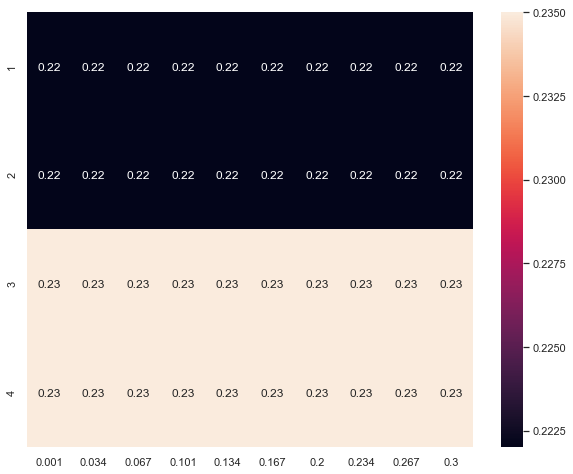

In [37]:
GridSearchLOF(0)

In [38]:
# the 0-th author
auth.iloc[0]

Author         DOGAN METIN
AbbrNames          DOGAN M
Affiliation     INONU UNIV
Name: 0, dtype: object

In [61]:
idx = 0
lof = LocalOutlierFactor(n_neighbors=2, contamination=0.001)
LOF_pred = lof.fit_predict(X_unlabeled[np.where(y_pred==idx)])
outlier_test,auth_df = LOF_result(paper_vec_test.copy(),auth.copy(),LOF_pred,idx,Abbrname)
outlier_test_LOF = outlier_test.loc[outlier_test.LOF==1].copy()
outlier_word = word_cnt(outlier_test)

outlier_word_LOF = word_cnt(outlier_test_LOF)
auth_df_word = word_cnt(auth_df)
print('Jaccard similarity before LOF:',get_jaccard_sim(outlier_word, auth_df_word))
print('Jaccard similarity after LOF(removing outliers):',get_jaccard_sim(outlier_word_LOF, auth_df_word))

Jaccard similarity before LOF: 0.235
Jaccard similarity after LOF(removing outliers): 0.222


The jaccard similarity dropped after LOF. The reason is that there are only 4 papers predicted to belong to DOGAN METIN, and both share same subject 'life sciences, biomedicine' in their subject list. So even removing one paper will hurt the jaccard similarity.

However, in latter two researchers, they have more samples and the effect of removing shraing subject will decrease so we continue on using jaccard similarity.

In [62]:
# show that all 4 papers have sharing subject 'life science, biomedicine'
outlier_test

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no,0,1,2,...,293,294,295,296,297,298,299,Label,LOF,kNN_prob
114,None,DOGAN MURAT,"[life, sciences, biomedicine, radiology, nuclear, medicine, medical, imaging]",Radiological and clinical course of pneumonia in patients with avian influenza H5N1,32469,"['avian-flu', 'lower respiratory tract infections', 'chest X-ray', 'clinic', 'ACUTE RESPIRATORY ...",9,-0.152039,0.036568,0.325653,...,0.291748,0.117401,0.065796,-0.078339,0.022552,0.224823,0.074814,-2.0,1,0.6
119,None,DOGAN M,"[technology, life, sciences, biomedicine, construction, building, technology, engineering, envir...","Geogenic arsenic and a survey of skin lesions in the Emet region of Kutahya, Turkey",2261483,"['arsenic', 'drinking water', 'skin disorders', 'environmental cancer', 'Emet', 'Turkey', 'DRINK...",1,-0.206928,-0.060242,0.205313,...,0.207144,0.099854,0.012408,0.025409,-0.058706,0.116089,0.117155,-2.0,-1,0.6
177,None,DOGAN M,"[life, sciences, biomedicine, clinical, neurology, neuroimaging, radiology, nuclear, medicine, m...",Diffusion-weighted imaging in chronic Behcet patients with and without neurological findings,551041,"[""Behcet's disease"", 'brain', 'diffusion-weighted imaging', 'CENTRAL-NERVOUS-SYSTEM', 'MULTIPLE-...",2,-0.152876,0.065302,0.272184,...,0.316939,0.119673,0.083585,-0.130682,0.012939,0.278209,0.056598,-2.0,1,0.6
764,None,DOGAN M,"[life, sciences, biomedicine, radiology, nuclear, medicine, medical, imaging]",Diffusion-weighted MR imaging of pleural fluid: differentiation of transudative vs exudative ple...,551041,"['diffusion weighting', 'MRI', 'pleural effusion', 'INTRAVOXEL INCOHERENT MOTION', 'IN-VIVO', 'B...",6,-0.152039,0.036568,0.325653,...,0.291748,0.117401,0.065796,-0.078339,0.022552,0.224823,0.074814,-2.0,1,0.6


`set(outlier_word)-set(outlier_word_LOF)` shows the subject difference after using LOF.
`auth_df_word` contains the subjects of all papers written by `DOGAN METIN`, `INONU UNIV`, and we can see that DOGAN METIN focus on life science, biomedicine and pharmacology.

Using LOF we remove papers in building, construction and environment domain. So LOF works well.

In [40]:
set(outlier_word)-set(outlier_word_LOF)

{'building',
 'construction',
 'engineering',
 'environmental',
 'health',
 'occupational',
 'public',
 'technology'}

In [41]:
auth_df_word.value_counts().head(10)

sciences        26
biomedicine     25
life            25
medicine         8
pharmacy         8
pharmacology     8
medical          4
research         4
experimental     4
microbiology     2
Name: Words, dtype: int64

In [42]:
# the final result of disambiguation
# unlabelled papers predicted to belong to DOGAN METIN
idx_ = [0,1,2,3,4,5,6,-1]
outlier_test_LOF.iloc[:,idx_]

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no,kNN_prob
114,None,DOGAN MURAT,"[life, sciences, biomedicine, radiology, nuclear, medicine, medical, imaging]",Radiological and clinical course of pneumonia in patients with avian influenza H5N1,32469,"['avian-flu', 'lower respiratory tract infections', 'chest X-ray', 'clinic', 'ACUTE RESPIRATORY ...",9,0.6
177,None,DOGAN M,"[life, sciences, biomedicine, clinical, neurology, neuroimaging, radiology, nuclear, medicine, m...",Diffusion-weighted imaging in chronic Behcet patients with and without neurological findings,551041,"[""Behcet's disease"", 'brain', 'diffusion-weighted imaging', 'CENTRAL-NERVOUS-SYSTEM', 'MULTIPLE-...",2,0.6
764,None,DOGAN M,"[life, sciences, biomedicine, radiology, nuclear, medicine, medical, imaging]",Diffusion-weighted MR imaging of pleural fluid: differentiation of transudative vs exudative ple...,551041,"['diffusion weighting', 'MRI', 'pleural effusion', 'INTRAVOXEL INCOHERENT MOTION', 'IN-VIVO', 'B...",6,0.6


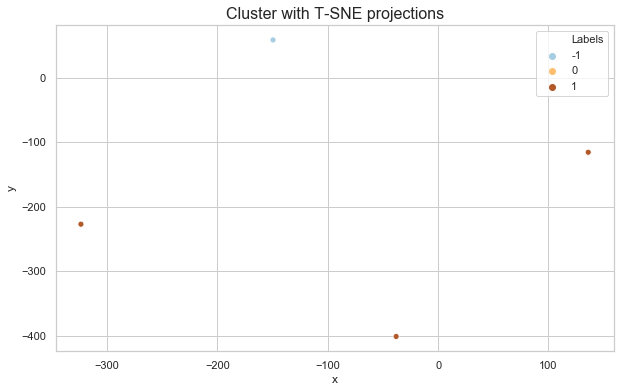

In [43]:
TSNE_plot(outlier_test.iloc[:,7:-3],outlier_test.LOF.get_values())

---

The best parameter pair is n_neighbor= 1 and contamiantion= 0.034


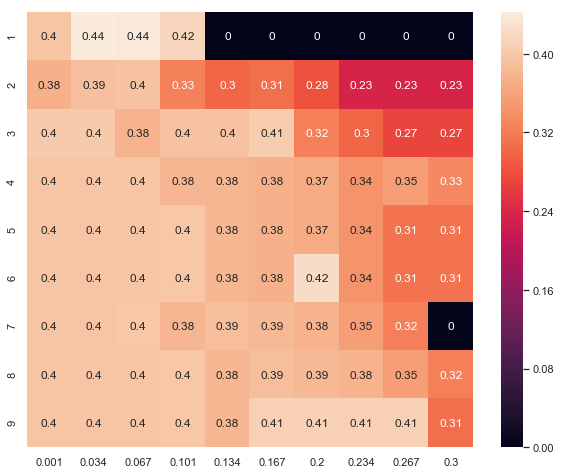

In [44]:
GridSearchLOF(1)

In [45]:
# name of 1-st author
auth.iloc[1]

Author                DOGAN MEVLUT
AbbrNames                  DOGAN M
Affiliation    AFYON KOCATEPE UNIV
Name: 1, dtype: object

In [46]:
idx = 1
lof = LocalOutlierFactor(n_neighbors=1, contamination=0.034)
LOF_pred = lof.fit_predict(X_unlabeled[np.where(y_pred==idx)])
outlier_test,auth_df = LOF_result(paper_vec_test.copy(),auth.copy(),LOF_pred,idx,Abbrname)
outlier_test_LOF = outlier_test.loc[outlier_test.LOF==1].copy()
outlier_word = word_cnt(outlier_test)
outlier_word_LOF = word_cnt(outlier_test_LOF)
auth_df_word = word_cnt(auth_df)
print('Jaccard similarity before LOF:',get_jaccard_sim(outlier_word, auth_df_word))
print('Jaccard similarity after LOF(removing outliers):',get_jaccard_sim(outlier_word_LOF, auth_df_word))

Jaccard similarity before LOF: 0.396
Jaccard similarity after LOF(removing outliers): 0.442


`set(outlier_word)-set(outlier_word_LOF)` shows the subject difference after using LOF.
`auth_df_word` contains the subjects of all papers written by `DOGAN MEVLUT` from `AFYON KOCATEPE UNIV`, and we can see that DOGAN METIN focus on physics, atom, optics and nuclear.

Using LOF we remove papers in automation control and electrical system domain. So LOF works well.

Also, we visualize the LOF result. label 1 for inlier, -1 for outlier.

In [47]:
set(outlier_word)-set(outlier_word_LOF)

{'automation', 'control', 'electrical', 'electronic', 'systems'}

In [48]:
auth_df_word.value_counts().head(10)

physics              41
physical             41
sciences             40
technology           18
chemical             16
molecular            16
atomic               16
multidisciplinary    16
optics               10
spectroscopy          7
Name: Words, dtype: int64

In [49]:
# the final result of disambiguation
# unlabelled papers predicted to belong to DOGAN MEVLUT
idx_ = [0,1,2,3,4,5,6,-1]
outlier_test_LOF.iloc[:,idx_]

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no,kNN_prob
19,None,DOGAN M,"[physical, sciences, polymer, science]",Study on conformational transition phenomena of poly(methyl methacrylate) in acetonitrile near t...,135243,"['poly(methyl methacrylate)', 'theta solvent', 'coil-globule transition', 'COIL-GLOBULE TRANSITI...",1,1.0
20,None,DOGAN M,"[physical, sciences, technology, chemistry, multidisciplinary, chemistry, physical, materials, s...",Determination of diffusion coefficient-vapor pressure product of some liquids from hanging drop ...,32469,"['ELLIPSOIDAL CAP GEOMETRY', 'PERIPHERAL CONTACT-ANGLE', 'SESSILE DROPS', 'POLYMER SURFACES', 'S...",2,1.0
49,None,DOGAN M,"[technology, metallurgy, metallurgical, engineering]",Dissolution kinetics of ulexite in aqueous EDTA solutions,12134330,"['AMMONIUM-CHLORIDE SOLUTION', 'CO2-SATURATED WATER', 'COLEMANITE', 'MINERALS', 'DIOXIDE']",4,0.8
58,None,DOGAN M,"[multidisciplinary, sciences]","Column chromatographic preconcentration and enrichment of copper, nickel and iron in ammonium sa...",32469,"['Amberlite XAD-16,Cu,Ni', 'ammonium nitrate', 'ammonium sulphate', 'determination', 'Fe', 'prec...",4,0.8
59,None,DOGAN M,"[physical, sciences, chemistry, analytical]",Determination of trace metal ions by AAS in natural water samples after preconcentration of pyro...,32469,"['preconcentration', 'activated carbon column', 'trace metal', 'natural waters', 'AAS', 'ATOMIC-...",4,1.0
70,None,DOGAN M,"[physical, sciences, chemistry, analytical]",SPECTROPHOTOMETRIC DETERMINATION OF TRACE AMOUNTS OF TUNGSTEN IN GEOLOGICAL SAMPLES AFTER PRECON...,32469,"['ATOMIC-ABSORPTION SPECTROMETRY', 'FLUORESCENCE SPECTROMETRY', 'METALS']",3,1.0
71,None,DOGAN M,"[physical, sciences, chemistry, analytical]",Determination of trace impurities in some nickel compounds by flame atomic absorption spectromet...,32469,"['HIGH-PURITY NICKEL', 'SPECTROPHOTOMETRIC DETERMINATION', 'PRECONCENTRATION', 'SEPARATION', 'PA...",5,1.0
81,None,DOGAN MEVLUT,"[technology, engineering, multidisciplinary, instruments, instrumentation]",Novel and traditional fringing field correction schemes for the hemispherical analyser: comparis...,814356,"['fringing fields', 'real apertures', 'slits', 'Herzog', 'Jost', 'paracentric entry', 'energy re...",4,0.8
103,None,DOGAN M,"[physical, sciences, chemistry, analytical]","Trace enrichment and atomic absorption spectrometric determination of lead, copper, cadmium and ...",32469,"['activated carbon column', 'copper', 'lead', 'cadmium', 'nickel', '1-(2-pyridylazo) 2-naphthol'...",3,1.0
109,None,DOGAN M,"[physical, sciences, chemistry, analytical]","Flame atomic absorption spectrometric determination of cadmium, cobalt, copper, lead and nickel ...",32469,"['enrichment', 'separation', 'trace metal ions', 'chemical grade potassium salts', 'FAAS', 'WATE...",3,1.0


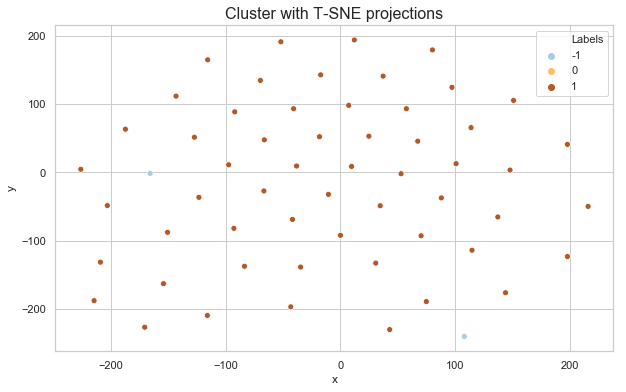

In [50]:
TSNE_plot(outlier_test.iloc[:,7:-3],outlier_test.LOF.get_values())

---

The best parameter pair is n_neighbor= 4 and contamiantion= 0.2


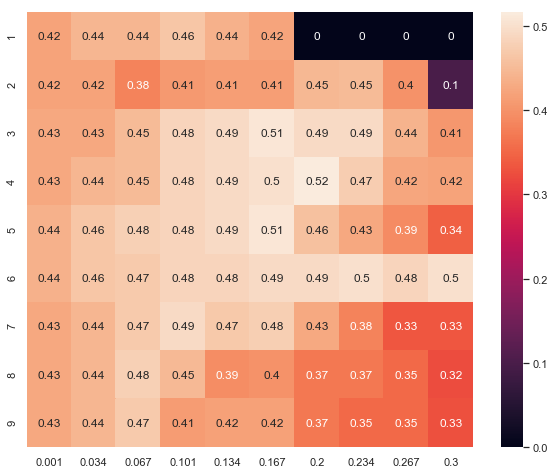

In [51]:
GridSearchLOF(3)

In [52]:
# 3-rd author
auth.iloc[3]

Author              DOGAN MURAT
AbbrNames               DOGAN M
Affiliation    YUZUNCU YIL UNIV
Name: 3, dtype: object

In [58]:
idx = 3
lof = LocalOutlierFactor(n_neighbors=4, contamination=0.2)
LOF_pred = lof.fit_predict(X_unlabeled[np.where(y_pred==idx)])
outlier_test,auth_df = LOF_result(paper_vec_test.copy(),auth.copy(),LOF_pred,idx,Abbrname)
outlier_test_LOF = outlier_test.loc[outlier_test.LOF==1].copy()
outlier_word = word_cnt(outlier_test)
outlier_word_LOF = word_cnt(outlier_test_LOF)
auth_df_word = word_cnt(auth_df)
print('Jaccard similarity before LOF:',get_jaccard_sim(outlier_word, auth_df_word))
print('Jaccard similarity after LOF(removing outliers):',get_jaccard_sim(outlier_word_LOF, auth_df_word))

Jaccard similarity before LOF: 0.421
Jaccard similarity after LOF(removing outliers): 0.516


`set(outlier_word)-set(outlier_word_LOF)` shows the subject difference after using LOF.
`auth_df_word` contains the subjects of all papers written by `DOGAN MURAT` from `YUZUNCU YIL UNIV`, and we can see that DOGAN MURAT focus on biomedicine, pediatrics and metabolism.

Using LOF we remove papers in atmospheric, meteorology, biodiversity, ecology and sociology domain. So LOF works well.

Also, we visualize the LOF result. label 1 for inlier, -1 for outlier.

In [59]:
set(outlier_word)-set(outlier_word_LOF)

{'agriculture',
 'analytical',
 'atmospheric',
 'biodiversity',
 'conservation',
 'ecology',
 'immunology',
 'meteorology',
 'otorhinolaryngology',
 'resources',
 'sociology',
 'transplantation',
 'veterinary',
 'water'}

In [55]:
auth_df_word.value_counts().head(10)

sciences         84
biomedicine      83
life             83
pediatrics       28
medicine         23
general          15
internal         15
metabolism       13
endocrinology    13
hematology       10
Name: Words, dtype: int64

In [56]:
# the final result of disambiguation
# unlabelled papers predicted to belong to DOGAN MURAT
idx_ = [0,1,2,3,4,5,6,-1]
outlier_test_LOF.iloc[:,idx_]

,Aff,Disp_name,Sub,Title,daisng_id,keywords,seq_no,kNN_prob
37,None,DOGAN MURAT,"[life, sciences, biomedicine, surgery]",Total thyroidectomy for the treatment of recurrent Graves' disease with ophthalmopathy,32469,"[""Graves' disease"", 'ophthalmopathy', 'thyroidectomy', 'TSH receptor antibody', 'SURGICAL-TREATM...",5,1.0
56,None,DOGAN M,"[life, sciences, biomedicine, immunology, surgery, transplantation]",Impact of calcineurin inhibitors on bone metabolism in primary kidney transplant patients,32469,"['CYCLOSPORINE-A', 'RENAL-TRANSPLANTATION', 'MINERAL METABOLISM', 'ORGAN-TRANSPLANTATION', 'PARA...",6,1.0
57,None,DOGAN M,"[life, sciences, biomedicine, biochemistry, molecular, biology, endocrinology, metabolism]","Atomic absorption-spectrometric determination of copper, cadmium, lead and nickel in urine sampl...",32469,"['column', 'activated carbon', 'enrichment', 'separation', 'trace metal', 'urine', 'TRACE AMOUNT...",4,0.8
89,None,DOGAN M,"[life, sciences, biomedicine, gastroenterology, hepatology, surgery]",Predictors of mortality and morbidity in acute obstructive jaundice: Implication of preventive m...,32469,"['obstructive jaundice', 'predictor factors', 'renal', 'failure', 'RENAL-FAILURE', 'BILIARY-TRAC...",7,0.8
93,None,DOGAN METIN,"[life, sciences, biomedicine, orthopedics, sport, sciences, surgery]",Synovial chondromatosis of four compartments of the knee: medial and lateral tibiofemoral spaces...,551041,"['synovial chondromatosis', 'proximal tibiofibular joint', 'knee', 'articular form']",3,0.8
104,None,DOGAN M,"[life, sciences, biomedicine, environmental, sciences]",Determination of some trace metal impurities in refined and unrefined salts after preconcentrati...,32469,"['refined and unrefined salts', 'activated carbon', 'FAAS', 'trace metal', 'ATOMIC-ABSORPTION SP...",3,0.8
112,None,DOGAN M,"[life, sciences, biomedicine, environmental, sciences]","PHYSICAL AND CHEMICAL-PROPERTIES OF MINERAL SPRING WATERS FROM THE CENTRAL REGION OF ANATOLIA, T...",32469,"['CHEMICAL ANALYSIS', 'MINERAL SPRING WATER', 'TRACE METALS']",2,0.8
115,None,DOGAN M,"[life, sciences, biomedicine, biotechnology, applied, microbiology, oncology]",The effect of venous thromboembolism on survival of cancer patients and its relationship with se...,32469,"['cancer', 'coagulation', 'venous thromboembolism', 'vascular endothelial growth factor', 'facto...",1,0.8
136,None,DOGAN MURAT,"[life, sciences, biomedicine, oncology, hematology, pediatrics]",Symptomatic hypoglycemia: An unusual side effect of oral purine analogues for treatment of ALL,32469,"['6-mercaptopurine', 'hypoglycemia', 'leukemia', 'ACUTE LYMPHOBLASTIC-LEUKEMIA', 'THERAPY', 'MET...",4,1.0
138,None,DOGAN M,"[life, sciences, biomedicine, food, science, technology]",Using fluid whey in comminuted meat products: Effects on textural properties of frankfurter-type...,543825,"['LOW-FAT', 'SENSORY PROPERTIES', 'BOLOGNA SAUSAGE', 'MUSCLE PROTEINS', 'SODIUM LACTATE', 'COLOR...",3,0.6


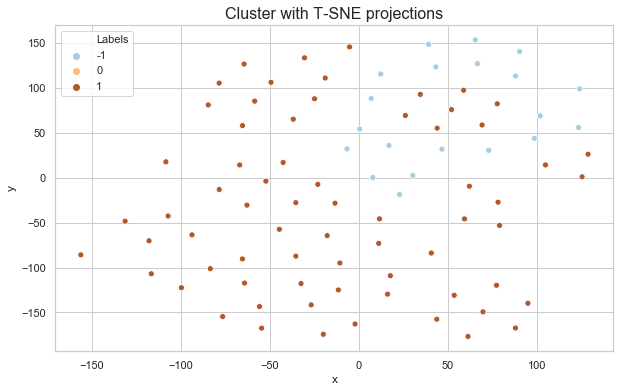

In [57]:
TSNE_plot(outlier_test.iloc[:,7:-3],outlier_test.LOF.get_values())

Because 2-nd author `DOGAN MUAMMER` from `AKSARAY UNIV` has no records in WOS so we skip it here.

And we notice that DOGAN MURAT and DOGAN METIN have very close subject and indeed, our prediction has misclassification on these two researchers(eg. in the prediction to DOGAN MURAT we see someone's full name is DOGAN METIN; and same happend in prediction to DOGAN METIN). And we also notice the misclassification actually has high kNN probability(eg. the probability of misclassified 'DOGAN METIN' in 'DOGAN MURAT' is 0.8).

It points out a defect of our code: we cannot disambiguate authors in same subject. Actually at first we have tried to use keywords as features to do disambiguation but the result was worse than subject features. We guessed that keywords are more specific and one author have many different keywords, it is harder for us to obtain general feature than using subjects. But, in the case that two authors in same subject, the more specific feature--keyword may be helpful.

So the next step to perfect disambiguation, we might use keywords as features to disambiguate authors in same subject.